In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from mpl_toolkits.mplot3d.axes3d import Axes3D
import h2o
import random
from sklearn import metrics
from sklearn import preprocessing
import xgboost as xgb
from sklearn import preprocessing
import math
import operator
import scipy.optimize as op
import scipy.io as sio
import pickle

In [2]:
# Functions Defined:
# mergedata: To combine user rating and movie information datasets
# costfunction and gradient: calculating costfunction and gradient for linear regression model
# generate_user_movie_matrix: To create a matrix of movies x users
# pickle_list and unpickle_list: To save and retrieve models
# predict_and_recommend: To recommend top n movies and give a list of the bottom n movies from list.

In [3]:
def mergedata(df_orig, df_newdata, keyID, new_column_list):
    # Fills in more fields (such as title etc from the dataframe df_newdata on to an existing df_orig. 
    # the keyID gives the key between the two dataframes)
    
    #df_all_data = df_orig
    
    # add new column names to the original dataframe
    for column_name in new_column_list:
        df_orig[column_name] = ''
        
    # list of all the distinct occurances of the keyID
    item_array = sorted(pd.unique(df_orig[keyID].ravel()))
    
    # for each ID in the list of keyIDs find the indices of rows in the original DF to append
    # then get the values for the keyID from df_newdata
    # finally, add these new values to the rows with the indices
    for item in item_array:
        ind_list = df_orig[df_orig[keyID] == item].index
        new_values = df_newdata.loc[df_newdata[df_newdata[keyID] == item].index, new_column_list].values
        df_orig.loc[ind_list, new_column_list] = new_values
    return df_orig

In [4]:
def costfunction(params, y, r, n, num_items, num_users,lam):
    # cost function for linear regression. the params variable contains feature vector for movies (x) 
    # and that for users (theta) all unrolled into one vector.
    # n: number of features, lam: regularization term
    
    x = params[0:num_items*n].reshape(num_items,n)
    theta = params[num_items*n : len(params)].reshape(num_users,n)
    prod_mat = (x.dot(np.transpose(theta)) - y)**2
    J = 1.0/2*sum(sum(prod_mat*r)) + (lam/2)*sum(sum(theta**2)) + (lam/2)*sum(sum(x**2))
    return J

In [5]:
def gradient(params, y, r, n, num_items, num_users,lam):
    # gradient function for linear regression. the params variable contains feature vector for movies (x) 
    # and that for users (theta) all unrolled into one vector.
    # n: number of features, lam: regularization term
    
    x = params[0:num_items*n].reshape(num_items,n)
    theta = params[num_items*n : len(params)].reshape(num_users,n)
    grad_mat = (x.dot(np.transpose(theta)) - y)*r
    x_grad = grad_mat.dot(theta) + lam*x
    theta_grad = np.transpose(grad_mat).dot(x) + lam*theta
    params_grad = np.c_[[x_grad.flatten()],[theta_grad.flatten()]].flatten()
    return params_grad

In [6]:
def generate_user_movie_matrix(df_userdata):
    # This function generates movie x user matrices: 
    # y: Uses the actual ratings given by users for different movies. 0 when unrated
    # y_norm: Uses the 'normalized' ratings by users for movies - Norm Rating is the rating given to a movie by a user 
    # minus the mean rating for that user.
    # r: A matrix where rij = 1 if movie i has been rated by user j, and 0 otherwise.

    #userID = 'UserID'
    #itemID = 'MovieID'
    #weight = 'Actual Rating'
    #normalized_weight = 'Norm_Rating'
    #mean_weight = 'Mean_Rating'

    # list of users and movies
    #user_array = sorted(pd.unique(df_userdata[userID].ravel()))
    #item_array = sorted(pd.unique(df_userdata[itemID].ravel()))
    #num_users = len(user_array)
    #num_items = len(item_array)

    # initialize matrices
    y = np.zeros((num_items,num_users), dtype = float)
    r = np.zeros_like(y)
    y_norm = np.zeros_like(y)

    # initialize mean rating and normalized rating columns
    df_userdata[normalized_weight] = 0
    df_userdata[mean_weight] = 0

    # loop over the users
    for idx in range(1,num_users+1):

        # Get the list of indices from the dataframe that correspond to ratings given by the current user
        user_index_list = df_userdata[df_userdata[userID] == idx].index
        num_items_user = len(user_index_list)

        #Derive a 'normalized' rating: for each user, find the mean of their ratings, and subtract this mean from 
        # each of their ratings. This helps account for differences in how different users rate movies.
        mean_rating = round(df_userdata[weight].loc[user_index_list].mean(),2)
        df_userdata[normalized_weight].loc[user_index_list] = df_userdata[weight].loc[user_index_list] - mean_rating
        df_userdata[mean_weight].loc[user_index_list]  = mean_rating

        # Get the matrix_index for movie ID (note: matrix_index = movieID - 1) and 
        # Ratings from the list of ratings by current user
        item_index_list = np.asarray(df_userdata[itemID].loc[user_index_list]) - 1
        rating_list =  np.asarray(df_userdata[weight].loc[user_index_list]).reshape(num_items_user,1)
        rating_list_norm = np.asarray(df_userdata[normalized_weight].loc[user_index_list]).reshape(num_items_user,1)

        # initialize a vector for the user to 0 and then assign the indices corresponding to the movies they rated to
        # the rating for that movie
        user_item_array = np.zeros((num_items,1))
        user_r_array = np.zeros_like(user_item_array)
        user_item_array_norm = np.zeros_like(user_item_array)
        user_item_array[item_index_list] = rating_list
        user_item_array_norm[item_index_list] = rating_list_norm
        user_r_array[item_index_list] = 1

        # update matrices y and r with values from current user
        y[:,idx-1] = user_item_array[:,0]
        y_norm[:, idx-1] = user_item_array_norm[:,0]
        r[:,idx-1] = user_r_array[:,0]
    return df_userdata, y, y_norm, r

In [7]:
def pickle_list(filename, listname):
    # To save a list and retrive later
    filename = filename + '.p'
    f = open(filename, 'w')
    pickle.dump(listname, f)
    f.close()
    return

In [8]:
def unpickle_list(filename):
    f = open(filename, 'r') 
    model_list = pickle.load(f)
    f.close()
    return model_list

In [23]:
def predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show):
    # This function shows a scatter plot of the predicted by actual ratings for the entire dataset for the model
    # that is fed into it. It then makes some predictions of best and worst movies for a given user
    

    # params_model is the model to be used
    # num_users: number of users, num_items: number of items, n: number of features
    # y_true: A vector containing all the ratings in the dataset, df_userdata: dataframe with user-movie data
    # df_movie: dataframe with the movie title, release date etc
    # test_userID: UserID number of the user for whom predictions will be made
    # num_rec: number of recommendations, Other_features_to_show: names of features to be printed
    
    
    # calculate the predicted parameters
    params_converged = params_model[0]
    x_fin = params_converged[0:num_items*n].reshape(num_items,n)
    theta_fin = params_converged[num_items*n : len(params_converged)].reshape(num_users,n)
    y_pred = x_fin.dot(np.transpose(theta_fin))
    y_predicted = y_pred.flatten()[np.nonzero(r.flatten())]

    # Plot y_predicted vs y_true
    plt.plot(y_true, y_predicted, '.')
    plt.xlabel('True Rating (Normalized)')
    plt.ylabel('Predicted Rating (Normalized)')
    plt.title('Predicted vs Actual Movie Rating (User-level Mean Subtracted)')
    plt.show()

    # Make recommendations for me
    theta_test = theta_fin[(test_userID -1), :].reshape(n, 1)
    ratings = x_fin.dot(theta_test)
    mean_rating = df_userdata[df_userdata['UserID']== test_userID].Mean_Rating.median()
    ratings = ratings + mean_rating
    df_testratings = pd.DataFrame({'Predicted Rating': ratings[:,0]})
    df_testuser = pd.concat([df_movie.loc[:,('MovieID', 'Movie Title', 'Release Date')], df_testratings], axis =1)
    df_testuser = pd.merge(df_testuser, df_userdata[df_userdata['UserID'] == test_userID].loc[:,('MovieID', 'Actual Rating')]
                           , how= 'outer', on= 'MovieID')
    df_testuser['Predicted Rating'] = df_testuser['Predicted Rating'].round(1)

    # Print recommendations
    print 'Top ', num_rec, ' Recommendations:'
    print df_testuser.sort_values(['Predicted Rating'], ascending = False)[Other_features_to_show].head(num_rec).to_string(index=False)
    print '\n'
    print 'Bottom ', num_rec, ' Movies:'
    print df_testuser.sort_values(['Predicted Rating'], ascending = False)[Other_features_to_show].tail(num_rec).to_string(index=False)
    
    return df_testuser
    

In [10]:
# INPUT DATA 

# 100k ratings from 944 users on 1682 movies. 
# The dataset is from grouplens, to which I have added my own movie ratings under user# 944.
file_path = '/Users/rekha/Documents/Machine Learning/Projects/ml-100k/u_mod.data'
feature_list = ['UserID', 'MovieID', 'Actual Rating', 'Timestamp']
df_userdata_input = pd.read_table(file_path, header = None, names = feature_list, sep = '\t')

# This file contains information about the movies. The list: column_list contains the names of the columns in this file
file_path_movies = '/Users/rekha/Documents/Bit Bootcamp/Projects/ml-100k/u.item'
column_list = ['MovieID', 'Movie Title', 'Release Date', 'Video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
             'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
             'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_movie = pd.read_table(file_path_movies, header = None, names = column_list, sep = '|')

# Add the movie name, genre, release date etc to the userdata
keyID = 'MovieID'
column_list.remove(keyID)
df_userdata = mergedata(df_userdata_input, df_movie, keyID, column_list)

In [12]:
# MOVIE x USER MATRIX

# y: The actual ratings given by users for different movies. 0 when unrated
# y_norm: the 'normalized' ratings by users for movies - Norm Rating is the rating given to a movie by a user 
# minus the mean rating for that user.
# r: A matrix where rij = 1 if movie i has been rated by user j, and 0 otherwise.

userID = 'UserID'
itemID = 'MovieID'
weight = 'Actual Rating'
normalized_weight = 'Norm_Rating'
mean_weight = 'Mean_Rating'

# list of users and movies
user_array = sorted(pd.unique(df_userdata[userID].ravel()))
item_array = sorted(pd.unique(df_userdata[itemID].ravel()))
num_users = len(user_array)
num_items = len(item_array)

df_userdata, y, y_norm, r = generate_user_movie_matrix(df_userdata)

In [13]:
# CHECK GRADIENT FUNCTION

# use a perturbation of epsilon = 1e-4 on each of the elements of a sample parameter set
# then evaluate the gradient: {costfunction(parameters + epsilon) - costfunction(parameters - epsilon)}/(2*epsilon)
# compare this to the gradient evaluated by the function. If the two look about the same, the gradient function works.

num_users_sample = 4
num_movies_sample = 5
num_features_sample = 3
x = np.random.normal(loc=0.0, scale=1.0, size=(num_movies_sample, num_features_sample))
theta = np.random.normal(loc=0.0, scale=1.0, size=(num_users_sample, num_features_sample))
params_sample = np.c_[[x.flatten()],[theta.flatten()]].flatten()

y_sample = y[0:num_movies_sample, 0:num_users_sample]
r_sample = r[0:num_movies_sample, 0:num_users_sample]

# check gradient
grad_sample = gradient(params_sample, y_sample, r_sample, num_features_sample, num_movies_sample, num_users_sample,1.5)

numgrad = np.zeros_like(params_sample)
perturb = np.zeros_like(params_sample)
epsilon = 1e-4
for p in range(0, len(params_sample)):
    #Set perturbation vector
    perturb[p] = epsilon
    params_sample_plus = params_sample + perturb
    params_sample_minus = params_sample - perturb
    J_plus = costfunction(params_sample_plus, y_sample, r_sample, num_features_sample, num_movies_sample, num_users_sample,1.5)
    J_minus = costfunction(params_sample_minus, y_sample, r_sample, num_features_sample, num_movies_sample, num_users_sample,1.5)
    #Compute Numerical Gradient
    numgrad[p] = (J_plus - J_minus) / (2*epsilon)
    perturb[p] = 0.0
    
print 'Gradient calculated by the function: '
print grad_sample
print 'Gradient calculated by perturbing the cost function: '
print numgrad

Gradient calculated by the function: 
[-5.50772433  3.05196941  1.079532   -2.53342767  2.75535368 -0.13516202
 -5.11068852 -0.69894065  2.03324118 -3.49489373 -1.03721657  0.95737604
 -3.37457083  3.00208857  1.99704403  9.37506412 -0.40384742  8.89269656
  1.14935955 -1.38466867  2.39096759 -1.28837521  0.32573242  0.30925082
  0.24067418 -1.7779833   0.60559134]
Gradient calculated by perturbing the cost function: 
[-5.50772433  3.05196941  1.079532   -2.53342767  2.75535368 -0.13516202
 -5.11068852 -0.69894065  2.03324118 -3.49489373 -1.03721657  0.95737604
 -3.37457083  3.00208857  1.99704403  9.37506412 -0.40384742  8.89269656
  1.14935955 -1.38466867  2.39096759 -1.28837521  0.32573242  0.30925082
  0.24067418 -1.7779833   0.60559134]


In [14]:
# TRAIN

# Train the dataset using n features. generate models for a range of features and a range of regularization paramters
# since the training data is relatively sparse wrt each user,  I have used the training regression fit (r^2) as a 
# guideline for model performance instead of making a validation cut and further reducing the training data available 
# The actual recommendations for me is another indicator of how well the model works

# The actual ratings unrolled to a vector, and the movie-user combinations with no ratings (rij = 0) are removed
# from this vector. A similar vector will be generated for each of the predictions for comparison
y_true = y_norm.flatten()[np.nonzero(r.flatten())]

# ranges for # features n and regularization term lam
n_min = 40
n_max = 200
n_step = 20
lam_min = 0
lam_max = 10
lam_step = 1

In [12]:

# Initialize lists for storing model, parameters, y_pred and r^2 values
model_list = []
param_list = []
y_pred_list = []
r2_list = []

# loop over n and lam
for n in range(n_min, n_max, n_step):
    for lam in range(lam_min, lam_max, lam_step):
        
        # generate random normal distribution of x and theta
        x = np.random.normal(loc=0.0, scale=1.0, size=(num_items, n))
        theta = np.random.normal(loc=0.0, scale=1.0, size=(num_users, n))
        params = np.c_[[x.flatten()],[theta.flatten()]].flatten()
        
        # model using L-BFGS-B minimizer
        params_model = op.fmin_l_bfgs_b(costfunction, params, fprime = gradient, 
                                args = (y_norm, r, n, num_items, num_users,lam), 
                                        factr = 1000, pgtol=1e-07, maxiter = 2000)
        # pull parameters from model
        params_converged = params_model[0]
        x_fin = params_converged[0:num_items*n].reshape(num_items,n)
        theta_fin = params_converged[num_items*n : len(params)].reshape(num_users,n)
        
        # predict user movie matrix and use the values that we actually rated to calculate r^2
        y_pred = x_fin.dot(np.transpose(theta_fin))
        y_predicted = y_pred.flatten()[np.nonzero(r.flatten())]
        r2 = metrics.r2_score(y_true, y_predicted)
        
        # append lists with the model, paramters, y_pred, r^2
        model_list.append(params_model)
        param_list.append(params_converged)
        y_pred_list.append(y_pred)
        r2_list.append(r2)

In [ ]:
# SAVE MODELS
filename = 'models'
pickle_list(filename, model_list)
filename = 'r2'
pickle_list(filename, r2_list)

In [15]:
# UNPICKLE MODELS (to be used when running the code again)
filename = 'models.p'
model_list = unpickle_list(filename)
filename = 'r2.p'
r2_list = unpickle_list(filename)

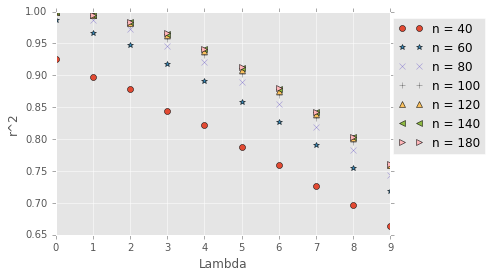

In [17]:
# Put all the model fits into a list and plot
n_feature_list = []
lam_list = []
for n in range(n_min, n_max, n_step):
    for lam in range(lam_min, lam_max, lam_step):
        n_feature_list.append(n)
        lam_list.append(lam)
df_r2 = pd.DataFrame({'n':n_feature_list, 'lambda': lam_list, 'r2': r2_list})

# plot
plt.plot(df_r2[df_r2['n'] == 40]['lambda'], df_r2[df_r2['n'] == 40]['r2'], 'o', label = 'n = 40')
plt.plot(df_r2[df_r2['n'] == 60]['lambda'], df_r2[df_r2['n'] == 60]['r2'], '*', label = 'n = 60')
plt.plot(df_r2[df_r2['n'] == 80]['lambda'], df_r2[df_r2['n'] == 80]['r2'], 'x', label = 'n = 80')
plt.plot(df_r2[df_r2['n'] == 100]['lambda'], df_r2[df_r2['n'] == 100]['r2'], '+', label = 'n = 100')
plt.plot(df_r2[df_r2['n'] == 120]['lambda'], df_r2[df_r2['n'] == 120]['r2'], '^', label = 'n = 120')
plt.plot(df_r2[df_r2['n'] == 140]['lambda'], df_r2[df_r2['n'] == 140]['r2'], '<', label = 'n = 140')
plt.plot(df_r2[df_r2['n'] == 180]['lambda'], df_r2[df_r2['n'] == 180]['r2'], '>', label = 'n = 180')
plt.xlabel('Lambda')
plt.ylabel('r^2')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [18]:
# Beyond n = 100 the fit appears to converge. This is a good number of features for this dataset
# Stretch the range of lamda beyond 9 for n = 100 to see how the model performs

n = 100
lam_min = 10
lam_max = 100
lam_step = 5

In [14]:
# Initialize lists for storing model, parameters, y_pred and r^2 values
model_list_2 = []
param_list_2 = []
y_pred_list_2 = []
r2_list_2 = []

# loop over lam
for lam in range(lam_min, lam_max, lam_step):

    # generate random normal distribution of x and theta
    x = np.random.normal(loc=0.0, scale=1.0, size=(num_items, n))
    theta = np.random.normal(loc=0.0, scale=1.0, size=(num_users, n))
    params = np.c_[[x.flatten()],[theta.flatten()]].flatten()

    # model using L-BFGS-B minimizer
    params_model = op.fmin_l_bfgs_b(costfunction, params, fprime = gradient, 
                            args = (y_norm, r, n, num_items, num_users,lam), 
                                    factr = 1000, pgtol=1e-07, maxiter = 2000)
    # pull parameters from model
    params_converged = params_model[0]
    x_fin = params_converged[0:num_items*n].reshape(num_items,n)
    theta_fin = params_converged[num_items*n : len(params)].reshape(num_users,n)

    # predict user movie matrix and use the values that we actually rated to calculate r^2
    y_pred = x_fin.dot(np.transpose(theta_fin))
    y_predicted = y_pred.flatten()[np.nonzero(r.flatten())]
    r2 = metrics.r2_score(y_true, y_predicted)

    # append lists with the model, paramters, y_pred, r^2
    model_list_2.append(params_model)
    param_list_2.append(params_converged)
    y_pred_list_2.append(y_pred)
    r2_list_2.append(r2)

In [16]:
# SAVE MODELS
filename = 'model_list_2'
pickle_list(filename, model_list_2)
filename = 'r2_2'
pickle_list(filename, r2_list_2)

In [19]:
# UNPICKLE MODELS (to be used when running the code again)
filename = 'model_list_2.p'
model_list_2 = unpickle_list(filename)
filename = 'r2_2.p'
r2_list_2 = unpickle_list(filename)

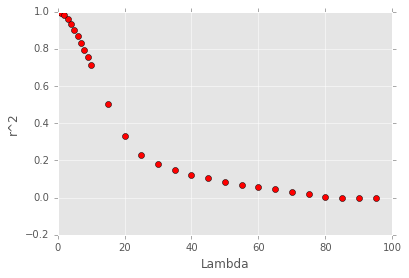

In [20]:
# PLOT
lam_list = []
for lam in range(lam_min, lam_max, lam_step):
    lam_list.append(lam)
df_r2_2 = pd.DataFrame({'lambda': lam_list, 'r2': r2_list_2})

# Plotting r^2 for n = 100 for a lambda range from 0 to 100
plt.plot(df_r2_2['lambda'], df_r2_2['r2'], 'o', label = 'n = 100', color = 'red')
plt.plot(df_r2[df_r2['n'] == 100]['lambda'], df_r2[df_r2['n'] == 100]['r2'], 'o', label = 'n = 100', color = 'red')
plt.xlabel('Lambda')
plt.ylabel('r^2')

In [21]:
# The conclusions from looking at the regression fits are: Above n = 100, the r^2 of the models converge. For a given
# n, the r^2 drops monotonically as lambda increases (which in turn reduces the theta & x values for reduced cost
# function)
# Test out models for my ratings using models with n = 100, lambda = 0, 5, 10, 15, 20, 30

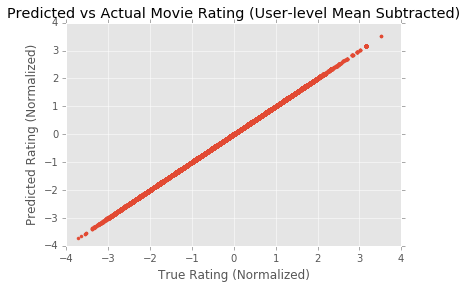

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
                    Kissed (1996)              28.2            NaN
             Sliding Doors (1998)              28.0            NaN
                Stalingrad (1993)              27.3            NaN
        Walk in the Sun, A (1945)              25.9            NaN
Children of the Revolution (1996)              25.4            NaN
           Victor/Victoria (1982)              25.2            NaN
                 Coneheads (1993)              24.6            NaN
     Three Caballeros, The (1945)              23.8            NaN
      Angel and the Badman (1947)              23.4            NaN
         Shadow Conspiracy (1997)              23.4            NaN
                 Mask, The (1994)              23.1            NaN
            Lashou shentan (1992)              22.9            NaN
             Nobody's Fool (1994)              22.6            NaN
                   Careful (1992)              22.5       

In [24]:
# PREDICT
# 1. lambda = 0, n = 100
model_index = 30
params_model = model_list[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser1 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

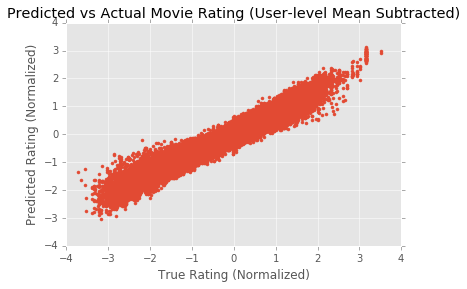

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
                 Field of Dreams (1989)               4.6            5.0
                   Trainspotting (1996)               4.6            NaN
                           Nixon (1995)               4.6            NaN
                     Taxi Driver (1976)               4.5            NaN
     Father of the Bride Part II (1995)               4.5            NaN
                   Donnie Brasco (1997)               4.5            5.0
         Speed 2: Cruise Control (1997)               4.4            5.0
                  Absolute Power (1997)               4.4            NaN
    Adventures of Pinocchio, The (1996)               4.4            5.0
         When Harry Met Sally... (1989)               4.4            NaN
                    Dante's Peak (1997)               4.4            NaN
                         Ed Wood (1994)               4.4            NaN
                  Godfather, The (1972)              

In [25]:
# PREDICT
# 2. lambda = 5, n = 100
model_index = 35
params_model = model_list[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser2 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

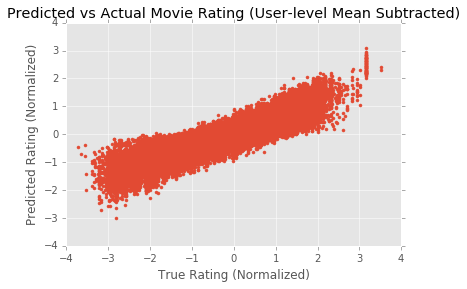

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
           Godfather, The (1972)               4.1            NaN
              Taxi Driver (1976)               4.1            NaN
          Field of Dreams (1989)               4.1            5.0
      Singin' in the Rain (1952)               4.0            NaN
             Citizen Kane (1941)               4.0            NaN
           Apocalypse Now (1979)               4.0            4.0
            Trainspotting (1996)               4.0            NaN
             Forrest Gump (1994)               4.0            NaN
                Chinatown (1974)               4.0            NaN
    To Kill a Mockingbird (1962)               4.0            NaN
             Sunset Blvd. (1950)               4.0            NaN
            Donnie Brasco (1997)               4.0            5.0
                   Casino (1995)               3.9            NaN
            McHale's Navy (1997)               3.9            NaN
     

In [26]:
# PREDICT
# 3. lambda = 10, n = 100
model_index = 0
params_model = model_list_2[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser3 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

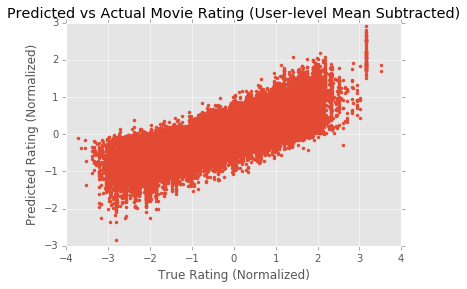

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
     Godfather: Part II, The (1974)               3.9            NaN
                 Taxi Driver (1976)               3.9            NaN
              Godfather, The (1972)               3.9            NaN
              Apocalypse Now (1979)               3.9            4.0
                   Toy Story (1995)               3.8            4.0
                Jackie Brown (1997)               3.8            NaN
              Cool Hand Luke (1967)               3.8            NaN
              Big Sleep, The (1946)               3.8            NaN
                      Gandhi (1982)               3.8            4.0
  Man Who Would Be King, The (1975)               3.8            NaN
         Killing Fields, The (1984)               3.8            NaN
                 Ulee's Gold (1997)               3.8            NaN
           Wizard of Oz, The (1939)               3.8            NaN
                Citizen Kane (19

In [28]:
# PREDICT
# 4. lambda = 15, n = 100
model_index = 1
params_model = model_list_2[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser4 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

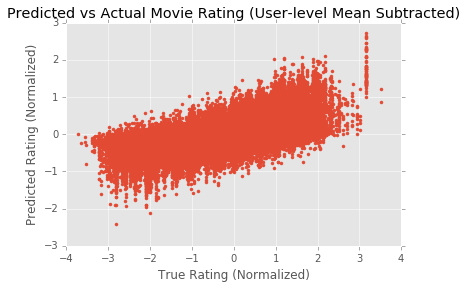

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
                                   Vertigo (1958)               3.8            NaN
                               Taxi Driver (1976)               3.8            NaN
                             Graduate, The (1967)               3.8            NaN
                            Third Man, The (1949)               3.8            NaN
                        Lawrence of Arabia (1962)               3.8            NaN
                                   Amadeus (1984)               3.8            NaN
                                 Chinatown (1974)               3.8            NaN
                   Godfather: Part II, The (1974)               3.8            NaN
                                    Psycho (1960)               3.8            NaN
                 Manchurian Candidate, The (1962)               3.8            NaN
                                GoodFellas (1990)               3.8            NaN
                

In [29]:
# PREDICT
# 5. lambda = 20, n = 100
model_index = 2
params_model = model_list_2[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser5 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

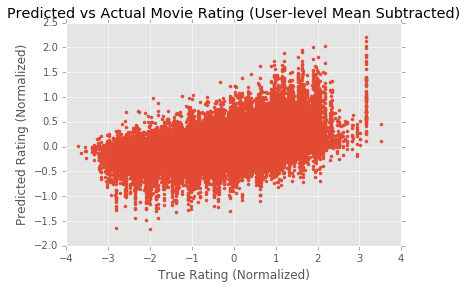

Top  20  Recommendations:
Movie Title  Predicted Rating  Actual Rating
                                     Fargo (1996)               3.8            NaN
                            Godfather, The (1972)               3.8            NaN
                                 Toy Story (1995)               3.7            4.0
                       Farewell to Arms, A (1932)               3.7            NaN
                            Get on the Bus (1996)               3.7            NaN
                  Escape to Witch Mountain (1975)               3.7            NaN
                         Feeling Minnesota (1996)               3.7            NaN
                                      Safe (1995)               3.7            NaN
                            Jupiter's Wife (1994)               3.7            NaN
                         Chungking Express (1994)               3.7            NaN
            Heidi Fleiss: Hollywood Madam (1995)                3.7            NaN
                

In [30]:
# PREDICT
# 6. lambda = 30, n = 100
model_index = 4
params_model = model_list_2[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 20
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser6 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)

In [31]:
# SAVE FINAL MODEL

# Based on the recommendations for me, lambda of 5-20 appear to make reasonable recommendations. lambda 0 and 30
# appear to not be doing a good job (0 is likely overfitting and 30 is underfitting). Based on this, use lambda 5-10 
# for a good r^2 without being in the region of overfitting

model_index = 35
params_model = model_list[model_index]
filename = 'final_model'
pickle_list(filename, params_model)

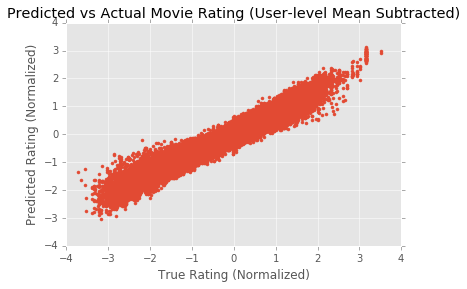

Top  40  Recommendations:
Movie Title  Predicted Rating  Actual Rating
                   Field of Dreams (1989)               4.6            5.0
                     Trainspotting (1996)               4.6            NaN
                             Nixon (1995)               4.6            NaN
                       Taxi Driver (1976)               4.5            NaN
       Father of the Bride Part II (1995)               4.5            NaN
                     Donnie Brasco (1997)               4.5            5.0
           Speed 2: Cruise Control (1997)               4.4            5.0
                    Absolute Power (1997)               4.4            NaN
      Adventures of Pinocchio, The (1996)               4.4            5.0
           When Harry Met Sally... (1989)               4.4            NaN
                      Dante's Peak (1997)               4.4            NaN
                           Ed Wood (1994)               4.4            NaN
                    Godfather

In [33]:
# SHOW FINAL MODEL
#lambda = 5, n = 100
model_index = 35
params_model = model_list[model_index]
n = 100
test_userID = 944
y_true = y_norm.flatten()[np.nonzero(r.flatten())]
num_rec = 40
Other_features_to_show = ['Movie Title', 'Predicted Rating', 'Actual Rating']

df_testuser2 = predict_and_recommend(params_model, num_users, num_items, n, y_true, df_userdata, df_movie, test_userID, 
                          num_rec, Other_features_to_show)